

## Summary
- Train and tune classification model
- Perform feature engineering to improve model performance
- Explain/interpret and debug model

## Tasks

The project will include following tasks:
- Load dataset. Don't use "index" column for training.
- Clean up the data:
    - Encode replace missing values
    - Replace features values that appear incorrect
    - Encode numerical variables that come as strings, for example string `$100.01` should be converted to numerical value
- Encode categorical variables
- Split dataset to Train/Test/Validation. If you perform cross-validation while tuning hyper-parameters, you don't need validation dataset.
- Adding engineered features. Simple encoding (Target encoding) for individual feature doesn't count to the 10 required engineered features
- Train and tune ML models
- Provide final metrics using Test (hold-out) dataset:
    - Classification: AUC
    - Confusion matrix for best F1
- Interpret final trained model using Test dataset:
    - Global feature importance using both Shapley values and permutation feature importance
    - Summary plot with Shapley values 
    - Individual observations analysis using Shapley values. Two records for each of the scenarios with significant probability:
        - Label `0` is correctly identified
        - Label `0` is identified as `1`
        - Label `1` is correctly identified
        - Label `1` is identified as `0`
        - Significant probability means high probability of being correct/in-correct (depending on the scenario)

## Datasets
There were several changes made to the dataset: columns dropped/added. 

The dataset is from the U.S. Small Business Administration (SBA) The U.S. SBA was founded in 1953 on the principle of promoting and assisting small enterprises in the U.S. credit market (SBA Overview and History, US Small Business Administration (2015)). Small businesses have been a primary source of job creation in the United States; therefore, fostering small business formation and growth has social benefits by creating job opportunities and reducing unemployment. There have been many success stories of start-ups receiving SBA loan guarantees such as FedEx and Apple Computer. However, there have also been stories of small businesses and/or start-ups that have defaulted on their SBA-guaranteed loans.  
More info on the original dataset: https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied.

## Models
train and tune two types of models:
- GBM (H2O)
- LightGBM. To install LightGBM, run following command from your terminal after activating class virtual environment:
train and tune 2 models for each task for the total of 2 final models. 

First, split he dataset to Train/Validation/Test, before applying any encodings clean-up or feature engineering. 
It is important to understand all the steps before model training, so that you can reliably replicate and test them to produce scoring function.

## Load Data example

Light GBM

In [1]:
import pandas as pd
df = pd.read_csv("SBA_loans_project_2(1).zip")

In [2]:
(df['MIS_Status'].value_counts()) / len(df) * 100

0    82.438293
1    17.561707
Name: MIS_Status, dtype: float64

In [3]:
df.isnull().sum()

index                   0
City                   26
State                  13
Zip                     0
Bank                 1347
BankState            1353
NAICS                   0
NoEmp                   0
NewExist              122
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            4090
LowDoc               2291
DisbursementGross       0
BalanceGross            0
GrAppv                  0
SBA_Appv                0
LoanInd                 0
MIS_Status              0
dtype: int64

In [4]:
null_cols = df.columns[df.isnull().any()]

# Replace null values in numerical columns with the mean of the column
for col in df.select_dtypes(include='number').columns:
    if col in null_cols:
        df[col].fillna(df[col].mean(), inplace=True)

# Replace null values in categorical columns with the mode of the column
for col in df.select_dtypes(include='object').columns:
    if col in null_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Print the updated dataframe to verify changes
print(df.head())

   index           City State    Zip                      Bank BankState  \
0      0      PRINCETON    MN  55371  PEOPLES BANK OF COMMERCE        MN   
1      1    Kansas city    MO  64116              BANK OF HAYS        KS   
2      2       BELLWOOD    PA  16617   FIRST COMMONWEALTH BANK        PA   
3      3  GRAND PRAIRIE    TX  75050           PROSPERITY BANK        TX   
4      4        EL PASO    TX  79925             WESTSTAR BANK        TX   

    NAICS  NoEmp  NewExist  CreateJob  ...  FranchiseCode  UrbanRural  \
0  441120      4       2.0          0  ...              1           0   
1  481111     14       1.0          0  ...              0           1   
2  334417     10       1.0          0  ...              1           1   
3       0     18       1.0          0  ...              1           0   
4  423220      4       1.0          0  ...              0           1   

   RevLineCr LowDoc DisbursementGross BalanceGross        GrAppv  \
0          N      N      $114,577.00

In [5]:
df.isnull().sum()

index                0
City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
GrAppv               0
SBA_Appv             0
LoanInd              0
MIS_Status           0
dtype: int64

In [6]:
c1=['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
df[c1] = df[c1].replace('[\$,]', '', regex=True).astype(float)

In [7]:
df.head()

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,...,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LoanInd,MIS_Status
0,0,PRINCETON,MN,55371,PEOPLES BANK OF COMMERCE,MN,441120,4,2.0,0,...,1,0,N,N,114577.0,0.0,114577.0,85933.0,1,0
1,1,Kansas city,MO,64116,BANK OF HAYS,KS,481111,14,1.0,0,...,0,1,N,N,25000.0,0.0,25000.0,12500.0,7,0
2,2,BELLWOOD,PA,16617,FIRST COMMONWEALTH BANK,PA,334417,10,1.0,0,...,1,1,0,N,85000.0,0.0,85000.0,42500.0,4,0
3,3,GRAND PRAIRIE,TX,75050,PROSPERITY BANK,TX,0,18,1.0,0,...,1,0,N,N,230000.0,0.0,230000.0,195500.0,5,0
4,4,EL PASO,TX,79925,WESTSTAR BANK,TX,423220,4,1.0,0,...,0,1,N,N,32000.0,0.0,32000.0,16000.0,9,0


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
# Split the data into training and testing sets with 70% for training
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the testing and validation sets equally
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

# Verify the shape of each set
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")


Training set: (565215, 20), (565215,)
Testing set: (121117, 20), (121117,)
Validation set: (121118, 20), (121118,)


In [9]:
train_ohe = pd.get_dummies(X_train[['LowDoc']])
X_train = pd.concat([X_train,train_ohe], axis=1)

In [10]:
X_train=X_train.drop(['LowDoc'],axis=1)

In [11]:
X_train.head()

,index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,...,SBA_Appv,LoanInd,LowDoc_0,LowDoc_1,LowDoc_A,LowDoc_C,LowDoc_N,LowDoc_R,LowDoc_S,LowDoc_Y
52431,52431,SIOUX FALLS,SD,57106,U.S. BANK NATIONAL ASSOCIATION,OH,445310,5,1.0,0,...,41850.0,8,0,0,0,0,1,0,0,0
645688,645688,HIGHLANDS RANCH,CO,80126,COMERICA BANK,CA,0,12,1.0,0,...,81000.0,7,0,0,0,0,1,0,0,0
207920,207920,MOUNT VERNON,WA,98273,HERITAGE BANK,WA,532230,3,1.0,0,...,63000.0,5,0,0,0,0,0,0,0,1
758666,758666,Lynnwood,WA,98036,CAPITAL ONE NATL ASSOC,VA,511210,10,1.0,0,...,50000.0,3,0,0,0,0,1,0,0,0
734445,734445,BURLINGTON,MA,1803,BANK OF AMERICA NATL ASSOC,RI,541310,1,1.0,0,...,12500.0,5,0,0,0,0,1,0,0,0


In [12]:
X_train = X_train.drop('index', axis=1)

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder

# create target encoder
encoder = TargetEncoder()

# fit on train set and transform both train and test sets
X_train = encoder.fit_transform(X_train, y_train)


In [14]:
test_ohe = pd.get_dummies(X_test[['LowDoc']])
X_test = pd.concat([X_test,test_ohe], axis=1)
X_test=X_test.drop(['LowDoc'],axis=1)
X_test = encoder.transform(X_test)
val_ohe = pd.get_dummies(X_val[['LowDoc']])
X_val = pd.concat([X_val,val_ohe], axis=1)
X_val=X_val.drop(['LowDoc'],axis=1)
X_val = encoder.transform(X_val)

In [15]:
te_columns = []
orig_categorical_columns = ["City", "State", "Bank", "BankState", "RevLineCr"]
for col in orig_categorical_columns:
    X_train[col+"_te"] = X_train[col]
    X_test[col+"_te"] = X_test[col]
    X_val[col+"_te"] = X_val[col]
    te_columns.append(col+"_te")

In [16]:
X_train=X_train.drop(["City",'State','Bank','BankState','RevLineCr'],axis=1)
X_test=X_test.drop(["City",'State','Bank','BankState','RevLineCr'],axis=1)    
X_val=X_val.drop(["City",'State','Bank','BankState','RevLineCr'],axis=1)

In [17]:
X_train.head()

,Zip,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,...,LowDoc_C,LowDoc_N,LowDoc_R,LowDoc_S,LowDoc_Y,City_te,State_te,Bank_te,BankState_te,RevLineCr_te
52431,57106,445310,5,1.0,0,0,1,0,46500.0,0.0,...,0,1,0,0,0,0.111111,0.083781,0.173050,0.157658,0.144873
645688,80126,0,12,1.0,0,0,77174,1,108000.0,0.0,...,0,1,0,0,0,0.269658,0.179177,0.165002,0.219103,0.144873
207920,98273,532230,3,1.0,0,0,1,0,70000.0,0.0,...,0,0,0,0,1,0.174419,0.143490,0.071664,0.076650,0.144873
758666,98036,511210,10,1.0,0,10,1,1,100000.0,0.0,...,0,1,0,0,0,0.209194,0.143490,0.412635,0.383535,0.144873
734445,1803,541310,1,1.0,0,1,1,1,58770.0,0.0,...,0,1,0,0,0,0.096257,0.129872,0.273317,0.204596,0.254863


In [18]:
def preprocess_data(df):
    df["Employment_Growth"] = (df["CreateJob"] - df["RetainedJob"])
    df["Employment_Opportunity"] = df["NoEmp"] * df["NewExist"]
    df['AppvDisbursed'] = (df["DisbursementGross"] == df["GrAppv"]).astype(int)
    df["Employees_more_than_10_and_GrAppv_100K"] = ((df['NoEmp'] > 10) & (df["GrAppv"] > 100000)).astype(int)
    df['SBA_AppvPct'] = df['SBA_Appv'] / (df['GrAppv'] + 1)
    df["NoEmp_per_CreateJob"] = df["NoEmp"] / (df["CreateJob"] + 1)
    df["DisbursementGross_per_Employee"] = df["DisbursementGross"] / (df["NoEmp"] + 1)
    df["DisbursementGross_per_CreateJob"] = df["DisbursementGross"] / (df["CreateJob"] + 1)
    df["DisbursementGross_BalanceGross_Ratio"] = df["DisbursementGross"] / (df["BalanceGross"] + 1)
    df["CreateJob_per_NoEmp"] = df["CreateJob"] / (df["NoEmp"] + 1)
    return df.drop(['Zip', 'FranchiseCode', 'NAICS', 'LoanInd'], axis=1)

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)
X_val = preprocess_data(X_val)


In [19]:
X_train.head()

,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,LowDoc_0,...,Employment_Growth,Employment_Opportunity,AppvDisbursed,Employees_more_than_10_and_GrAppv_100K,SBA_AppvPct,NoEmp_per_CreateJob,DisbursementGross_per_Employee,DisbursementGross_per_CreateJob,DisbursementGross_BalanceGross_Ratio,CreateJob_per_NoEmp
52431,5,1.0,0,0,0,46500.0,0.0,46500.0,41850.0,0,...,0,5.0,1,0,0.899981,5.0,7750.000000,46500.0,46500.0,0.0
645688,12,1.0,0,0,1,108000.0,0.0,108000.0,81000.0,0,...,0,12.0,1,1,0.749993,12.0,8307.692308,108000.0,108000.0,0.0
207920,3,1.0,0,0,0,70000.0,0.0,70000.0,63000.0,0,...,0,3.0,1,0,0.899987,3.0,17500.000000,70000.0,70000.0,0.0
758666,10,1.0,0,10,1,100000.0,0.0,100000.0,50000.0,0,...,-10,10.0,1,0,0.499995,10.0,9090.909091,100000.0,100000.0,0.0
734445,1,1.0,0,1,1,58770.0,0.0,25000.0,12500.0,0,...,-1,1.0,0,0,0.499980,1.0,29385.000000,58770.0,58770.0,0.0


In [20]:
X_train.columns

Index(['NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'UrbanRural',
       'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'LowDoc_0',
       'LowDoc_1', 'LowDoc_A', 'LowDoc_C', 'LowDoc_N', 'LowDoc_R', 'LowDoc_S',
       'LowDoc_Y', 'City_te', 'State_te', 'Bank_te', 'BankState_te',
       'RevLineCr_te', 'Employment_Growth', 'Employment_Opportunity',
       'AppvDisbursed', 'Employees_more_than_10_and_GrAppv_100K',
       'SBA_AppvPct', 'NoEmp_per_CreateJob', 'DisbursementGross_per_Employee',
       'DisbursementGross_per_CreateJob',
       'DisbursementGross_BalanceGross_Ratio', 'CreateJob_per_NoEmp'],
      dtype='object')

In [21]:
import numpy as np
import optuna
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [22]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 10, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'max_depth': trial.suggest_int('max_depth', -1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.5),
    }
    gbm = lgb.LGBMClassifier(**params)
    gbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    y_pred_val = gbm.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    return f1

In [23]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=150)

[I 2023-05-07 18:11:00,878] A new study created in memory with name: no-name-b597572e-af6b-46bb-9df0-01047d185984
C:\Users\haric\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\haric\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2023-05-07 18:11:02,376] Trial 0 finished with value: 0.2677434030937216 and parameters: {'n_estimators': 118, 'learning_rate': 0.19019214697557332, 'num_leaves': 40, 'min_child_s

In [24]:
best_params = study.best_params
print("Best parameters found: ", best_params)
gbm = lgb.LGBMClassifier(**best_params)
gbm.fit(X_train, y_train)

Best parameters found:  {'n_estimators': 75, 'learning_rate': 0.19268128534868167, 'num_leaves': 10, 'min_child_samples': 49, 'max_depth': -1, 'colsample_bytree': 0.9564572454792284, 'subsample': 0.8110804436345199, 'reg_alpha': 1.4894471941789504, 'reg_lambda': 0.11069484710309829}


LGBMClassifier(colsample_bytree=0.9564572454792284,
               learning_rate=0.19268128534868167, min_child_samples=49,
               n_estimators=75, num_leaves=10, reg_alpha=1.4894471941789504,
               reg_lambda=0.11069484710309829, subsample=0.8110804436345199)

In [25]:
thresholds = np.arange(0, 1.01, 0.01)
best_threshold = 0
best_f1 = 0
y_pred_proba_val = gbm.predict_proba(X_val)[:, 1]
for threshold in thresholds:
    y_pred_val = (y_pred_proba_val >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_val)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
print("Best threshold to maximize F1 score: ", best_threshold)

Best threshold to maximize F1 score:  0.23


In [26]:
from sklearn.metrics import precision_recall_fscore_support

y_pred_proba_test = gbm.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_proba_test >= best_threshold).astype(int)

precision, recall, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='macro')
accuracy_test = accuracy_score(y_test, y_pred_test)

print("F1 score on test set (macro): ", f1_test)
print("Accuracy on test set: ", accuracy_test)


F1 score on test set (macro):  0.6666640695993614
Accuracy on test set:  0.7777190650362872


In [27]:
import shap

# Define a function that generates predictions from the model
def predict(X):
    return gbm.predict(X)

# Create an explainer object with the function and the training data
explainer = shap.Explainer(predict, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test)


Permutation explainer: 121118it [1:27:21, 23.07it/s]                                                                   


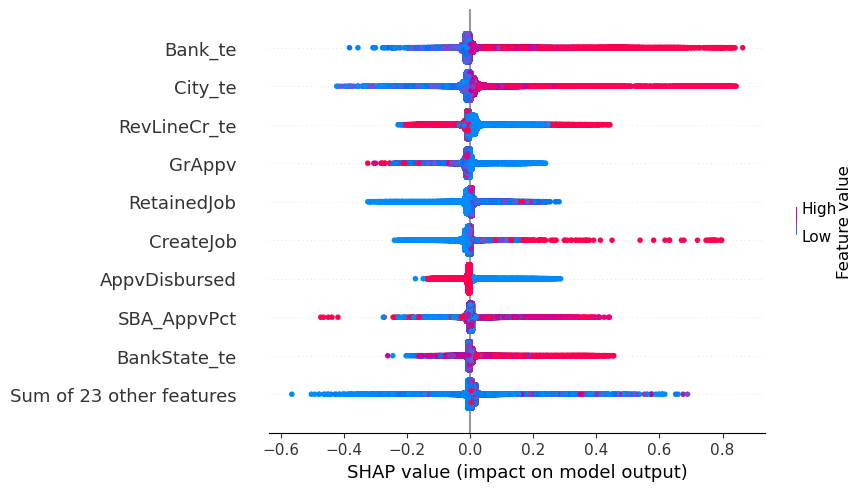

In [28]:
shap.plots.beeswarm(shap_values)

In [29]:
import pickle

artifacts_dict = {
    "model": gbm,
    "best_threshold": best_threshold,
    "encoder": encoder
}

artifacts_dict_file = open("project2_model.pkl", "wb")
pickle.dump(obj=artifacts_dict, file=artifacts_dict_file)
artifacts_dict_file.close()


H2O

In [30]:
import h2o
import pandas as pd
# Initialize H2O cluster
h2o.init()
# Convert pandas dataframe to H2O dataframe
h2o_df = h2o.H2OFrame(df)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 19.0.2+7-44, mixed mode, sharing)
  Starting server from C:\Users\haric\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\haric\AppData\Local\Temp\tmprglteysu
  JVM stdout: C:\Users\haric\AppData\Local\Temp\tmprglteysu\h2o_haric_started_from_python.out
  JVM stderr: C:\Users\haric\AppData\Local\Temp\tmprglteysu\h2o_haric_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_haric_9vb4rx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.961 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [31]:
# Split the data into train, test, and validation sets
train, test, valid = h2o_df.split_frame(ratios=[0.7, 0.15], seed=123)

In [32]:
# Convert the 'LowDoc' column to a factor (categorical variable)
h2o_df['LowDoc'] = h2o_df['LowDoc'].asfactor()

# Get the unique levels of the 'LowDoc' column
unique_levels = h2o_df['LowDoc'].unique()

# Perform one-hot encoding
for level in unique_levels.as_data_frame(use_pandas=True).iloc[:, 0]:
    new_col_name = f"LowDoc_{level}"
    one_hot_column = (h2o_df['LowDoc'] == level).ifelse(1, 0)
    one_hot_column.set_names([new_col_name])
    h2o_df = h2o_df.cbind(one_hot_column)

# Remove the original 'LowDoc' column
h2o_df = h2o_df.drop('LowDoc')

In [33]:
# Get the unique levels of the 'LowDoc' column across all datasets
unique_levels_train = train['LowDoc'].unique().as_data_frame(use_pandas=True).iloc[:, 0].tolist()
unique_levels_test = test['LowDoc'].unique().as_data_frame(use_pandas=True).iloc[:, 0].tolist()
unique_levels_valid = valid['LowDoc'].unique().as_data_frame(use_pandas=True).iloc[:, 0].tolist()
unique_levels = set(unique_levels_train + unique_levels_test + unique_levels_valid)

# Perform one-hot encoding for all datasets
for level in unique_levels:
    new_col_name = f"LowDoc_{level}"
    train_one_hot_column = (train['LowDoc'] == level).ifelse(1, 0)
    train_one_hot_column.set_names([new_col_name])
    train = train.cbind(train_one_hot_column)
    
    test_one_hot_column = (test['LowDoc'] == level).ifelse(1, 0)
    test_one_hot_column.set_names([new_col_name])
    test = test.cbind(test_one_hot_column)
    
    valid_one_hot_column = (valid['LowDoc'] == level).ifelse(1, 0)
    valid_one_hot_column.set_names([new_col_name])
    valid = valid.cbind(valid_one_hot_column)

# Remove the original 'LowDoc' column for all datasets
train = train.drop('LowDoc')
test = test.drop('LowDoc')
valid = valid.drop('LowDoc')


In [34]:
# Choose which columns to encode
cat_columns = ["City", "State", "Bank", "BankState", "RevLineCr"]
response = "MIS_Status"

train[cat_columns+[response]] = train[cat_columns+[response]].asfactor()

In [35]:
from h2o.estimators import H2OTargetEncoderEstimator
# Train a Target Encoder model
data_te = H2OTargetEncoderEstimator(#fold_column=fold_column,
                                    data_leakage_handling=None,
                                    blending=True,
                                    inflection_point=3,
                                    smoothing=10,
                                    noise=0.15,     
                                    seed=1234)

data_te.train(x=cat_columns,
              y=response,
              training_frame=train)

# New target encoded dataset
train = data_te.transform(frame=train, as_training=True)
test = data_te.transform(frame=test, as_training=False)
valid = data_te.transform(frame=valid, as_training=False)


predictors = train.columns
for col in cat_columns+[response]:
    predictors.remove(col)

targetencoder Model Build progress: |████████████████████████████████████████████| (done) 100%


In [36]:
# Columns to drop
columns_to_drop = ["City", "State", "Bank", "BankState", "RevLineCr"]

# Drop the specified columns from the train dataset
train = train.drop(columns_to_drop)

# Drop the specified columns from the test dataset
test = test.drop(columns_to_drop)

# Drop the specified columns from the valid dataset
valid = valid.drop(columns_to_drop)


In [37]:
def feature_engineering(data):
    data['Employment_Growth'] = data['CreateJob'] - data['RetainedJob']
    data['Employment_Opportunity'] = data['NoEmp'] * data['NewExist']
    data['Employees_more_than_10'] = (data['NoEmp'] > 10).ifelse(1, 0)
    data['GrAppv_more_than100k'] = (data['GrAppv'] > 100000).ifelse(1, 0)
    data['SBA_AppvPct'] = data['SBA_Appv'] / (data['GrAppv'] + 1)
    data = data.drop(['Zip', 'FranchiseCode'], axis=1)
    data['NoEmp_per_CreateJob'] = data['NoEmp'] / (data['CreateJob'] + 1)
    data['DisbursementGross_per_Employee'] = data['DisbursementGross'] / (data['NoEmp'] + 1)
    data['DisbursementGross_per_CreateJob'] = data['DisbursementGross'] / (data['CreateJob'] + 1)
    data['DisbursementGross_BalanceGross_Ratio'] = data['DisbursementGross'] / (data['BalanceGross'] + 1)
    data['CreateJob_per_NoEmp'] = data['CreateJob'] / (data['NoEmp'] + 1)
    
    return data

test = feature_engineering(test)
train = feature_engineering(train)
valid = feature_engineering(valid)


In [38]:
import pandas as pd
import optuna
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

resp_var = "MIS_Status"
gbm_predictors = train.columns
gbm_predictors.remove(resp_var)
train_df = train.as_data_frame()
X_train = train_df[gbm_predictors]
y_train = train_df[resp_var]

In [39]:
# Define objective function for Optuna
def optuna_objective(trial):
    tree_num = trial.suggest_int('ntrees', 10, 150)
    depth_max = trial.suggest_int('max_depth', 3, 9)
    rate_sample = trial.suggest_float('sample_rate', 0.5, 1.0)
    rate_col_sample = trial.suggest_float('col_sample_rate', 0.5, 1.0)

    gbm_model = H2OGradientBoostingEstimator(nfolds=5,
                                             seed=1111,
                                             ntrees=tree_num,
                                             max_depth=depth_max,
                                             sample_rate=rate_sample,
                                             col_sample_rate=rate_col_sample,
                                             keep_cross_validation_predictions=False)
    
    gbm_model.train(x=gbm_predictors, y=resp_var, training_frame=train, validation_frame=valid)
    return gbm_model.auc(valid=True)


In [40]:
# Run Optuna optimization
optuna_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1111))
optuna_study.optimize(optuna_objective, n_trials=100)#It takes lot of processing time


[I 2023-05-07 19:43:01,561] A new study created in memory with name: no-name-18833534-a059-4192-999d-270604b2957e


gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:43:26,870] Trial 0 finished with value: 0.784246958045524 and parameters: {'ntrees': 23, 'max_depth': 9, 'sample_rate': 0.6717867116036095, 'col_sample_rate': 0.655238470934922}. Best is trial 0 with value: 0.784246958045524.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:43:33,464] Trial 1 finished with value: 0.750284370445797 and parameters: {'ntrees': 10, 'max_depth': 4, 'sample_rate': 0.6188958600791898, 'col_sample_rate': 0.8679579366203547}. Best is trial 0 with value: 0.784246958045524.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:44:25,809] Trial 2 finished with value: 0.7918246553492442 and parameters: {'ntrees': 79, 'max_depth': 8, 'sample_rate': 0.5632531556039517, 'col_sample_rate': 0.8033246597503303}. Best is trial 2 with value: 0.7918246553492442.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:44:56,149] Trial 3 finished with value: 0.7718987662147012 and parameters: {'ntrees': 75, 'max_depth': 4, 'sample_rate': 0.7175795912387604, 'col_sample_rate': 0.6218357571377213}. Best is trial 2 with value: 0.7918246553492442.


█| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


[I 2023-05-07 19:45:39,044] Trial 4 finished with value: 0.7912181330799024 and parameters: {'ntrees': 64, 'max_depth': 8, 'sample_rate': 0.8275923636716016, 'col_sample_rate': 0.5742233364442924}. Best is trial 2 with value: 0.7918246553492442.


gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:46:43,876] Trial 5 finished with value: 0.791692845676215 and parameters: {'ntrees': 100, 'max_depth': 7, 'sample_rate': 0.8054371470771224, 'col_sample_rate': 0.965009276100955}. Best is trial 2 with value: 0.7918246553492442.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 19:47:53,753] Trial 6 finished with value: 0.7925270224170524 and parameters: {'ntrees': 125, 'max_depth': 8, 'sample_rate': 0.5427004631547709, 'col_sample_rate': 0.8325013642483752}. Best is trial 6 with value: 0.7925270224170524.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:48:58,372] Trial 7 finished with value: 0.7923832736322506 and parameters: {'ntrees': 110, 'max_depth': 9, 'sample_rate': 0.6340043184023714, 'col_sample_rate': 0.6215383628125433}. Best is trial 6 with value: 0.7925270224170524.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:49:54,587] Trial 8 finished with value: 0.7876286366232063 and parameters: {'ntrees': 121, 'max_depth': 5, 'sample_rate': 0.8972397381473802, 'col_sample_rate': 0.9336655139626157}. Best is trial 6 with value: 0.7925270224170524.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 19:51:05,190] Trial 9 finished with value: 0.7938347977738867 and parameters: {'ntrees': 122, 'max_depth': 9, 'sample_rate': 0.6355613839068042, 'col_sample_rate': 0.8804274770594925}. Best is trial 9 with value: 0.7938347977738867.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:52:16,776] Trial 10 finished with value: 0.7904993117272973 and parameters: {'ntrees': 142, 'max_depth': 6, 'sample_rate': 0.9983815687936208, 'col_sample_rate': 0.7197707353179779}. Best is trial 9 with value: 0.7938347977738867.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 19:53:23,957] Trial 11 finished with value: 0.7921813962733996 and parameters: {'ntrees': 141, 'max_depth': 7, 'sample_rate': 0.500403792187252, 'col_sample_rate': 0.8298370082914582}. Best is trial 9 with value: 0.7938347977738867.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 19:54:34,508] Trial 12 finished with value: 0.7936756284232546 and parameters: {'ntrees': 124, 'max_depth': 9, 'sample_rate': 0.5372292674515176, 'col_sample_rate': 0.8938612658209701}. Best is trial 9 with value: 0.7938347977738867.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 19:55:44,754] Trial 13 finished with value: 0.7933387871203464 and parameters: {'ntrees': 102, 'max_depth': 9, 'sample_rate': 0.6367044229302184, 'col_sample_rate': 0.9976944548090521}. Best is trial 9 with value: 0.7938347977738867.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:56:31,897] Trial 14 finished with value: 0.7731226380094066 and parameters: {'ntrees': 150, 'max_depth': 3, 'sample_rate': 0.5738983904103485, 'col_sample_rate': 0.9006546813349586}. Best is trial 9 with value: 0.7938347977738867.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:57:02,336] Trial 15 finished with value: 0.7847323217950156 and parameters: {'ntrees': 44, 'max_depth': 7, 'sample_rate': 0.5081884326049778, 'col_sample_rate': 0.9107697853750275}. Best is trial 9 with value: 0.7938347977738867.


█| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


[I 2023-05-07 19:58:13,046] Trial 16 finished with value: 0.7941602830401188 and parameters: {'ntrees': 126, 'max_depth': 9, 'sample_rate': 0.7050724990442061, 'col_sample_rate': 0.767020728293506}. Best is trial 16 with value: 0.7941602830401188.


gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 19:59:01,035] Trial 17 finished with value: 0.7886760004912637 and parameters: {'ntrees': 92, 'max_depth': 6, 'sample_rate': 0.7077549989959244, 'col_sample_rate': 0.7644338542354666}. Best is trial 16 with value: 0.7941602830401188.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:00:03,976] Trial 18 finished with value: 0.7925723105915888 and parameters: {'ntrees': 131, 'max_depth': 8, 'sample_rate': 0.7488604056402846, 'col_sample_rate': 0.5014714972856844}. Best is trial 16 with value: 0.7941602830401188.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:01:07,082] Trial 19 finished with value: 0.7918857967927087 and parameters: {'ntrees': 112, 'max_depth': 7, 'sample_rate': 0.6940996648879284, 'col_sample_rate': 0.7521620174856634}. Best is trial 16 with value: 0.7941602830401188.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:01:51,347] Trial 20 finished with value: 0.7911106272516324 and parameters: {'ntrees': 58, 'max_depth': 9, 'sample_rate': 0.5942609591257502, 'col_sample_rate': 0.7086009823429067}. Best is trial 16 with value: 0.7941602830401188.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:03:03,068] Trial 21 finished with value: 0.7939333709861041 and parameters: {'ntrees': 130, 'max_depth': 9, 'sample_rate': 0.6534138662444985, 'col_sample_rate': 0.8726026303407548}. Best is trial 16 with value: 0.7941602830401188.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:04:12,962] Trial 22 finished with value: 0.7929989223251973 and parameters: {'ntrees': 138, 'max_depth': 8, 'sample_rate': 0.6653560512540504, 'col_sample_rate': 0.8590813831828965}. Best is trial 16 with value: 0.7941602830401188.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:05:20,389] Trial 23 finished with value: 0.7929667292619265 and parameters: {'ntrees': 115, 'max_depth': 9, 'sample_rate': 0.6209180249870511, 'col_sample_rate': 0.7905024399441992}. Best is trial 16 with value: 0.7941602830401188.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:06:22,212] Trial 24 finished with value: 0.7928073174748068 and parameters: {'ntrees': 92, 'max_depth': 8, 'sample_rate': 0.6612261937439963, 'col_sample_rate': 0.848456501429401}. Best is trial 16 with value: 0.7941602830401188.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:07:32,562] Trial 25 finished with value: 0.7936715173897303 and parameters: {'ntrees': 149, 'max_depth': 9, 'sample_rate': 0.5963649574545834, 'col_sample_rate': 0.800619125709232}. Best is trial 16 with value: 0.7941602830401188.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:08:46,309] Trial 26 finished with value: 0.792991784494553 and parameters: {'ntrees': 135, 'max_depth': 8, 'sample_rate': 0.7431746333124803, 'col_sample_rate': 0.941372013539105}. Best is trial 16 with value: 0.7941602830401188.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:09:47,651] Trial 27 finished with value: 0.7928293312744201 and parameters: {'ntrees': 103, 'max_depth': 7, 'sample_rate': 0.6823654176348556, 'col_sample_rate': 0.8739890366075564}. Best is trial 16 with value: 0.7941602830401188.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:10:29,183] Trial 28 finished with value: 0.7841589262172872 and parameters: {'ntrees': 89, 'max_depth': 5, 'sample_rate': 0.7113495986388376, 'col_sample_rate': 0.8164363217690888}. Best is trial 16 with value: 0.7941602830401188.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:11:41,114] Trial 29 finished with value: 0.7942117841512798 and parameters: {'ntrees': 130, 'max_depth': 9, 'sample_rate': 0.6696283391201072, 'col_sample_rate': 0.8862752427470799}. Best is trial 29 with value: 0.7942117841512798.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:12:10,829] Trial 30 finished with value: 0.7888547446407412 and parameters: {'ntrees': 35, 'max_depth': 9, 'sample_rate': 0.6727356356613042, 'col_sample_rate': 0.7186659390510872}. Best is trial 29 with value: 0.7942117841512798.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:13:22,871] Trial 31 finished with value: 0.7938533317718819 and parameters: {'ntrees': 129, 'max_depth': 9, 'sample_rate': 0.6597020355552378, 'col_sample_rate': 0.8751205117224476}. Best is trial 29 with value: 0.7942117841512798.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:14:33,776] Trial 32 finished with value: 0.794305592436039 and parameters: {'ntrees': 131, 'max_depth': 9, 'sample_rate': 0.6598271462935372, 'col_sample_rate': 0.8433615794982756}. Best is trial 32 with value: 0.794305592436039.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:15:39,422] Trial 33 finished with value: 0.7931031704869365 and parameters: {'ntrees': 118, 'max_depth': 8, 'sample_rate': 0.6073124718621532, 'col_sample_rate': 0.8383210169615078}. Best is trial 32 with value: 0.794305592436039.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:15:50,868] Trial 34 finished with value: 0.7766954830688745 and parameters: {'ntrees': 10, 'max_depth': 9, 'sample_rate': 0.7199605317017284, 'col_sample_rate': 0.7874946967765556}. Best is trial 32 with value: 0.794305592436039.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:17:00,032] Trial 35 finished with value: 0.7930644559529714 and parameters: {'ntrees': 134, 'max_depth': 8, 'sample_rate': 0.686611547348394, 'col_sample_rate': 0.8606720470859573}. Best is trial 32 with value: 0.794305592436039.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:18:12,444] Trial 36 finished with value: 0.7940226260917295 and parameters: {'ntrees': 145, 'max_depth': 8, 'sample_rate': 0.7669034025206145, 'col_sample_rate': 0.8117880394341789}. Best is trial 32 with value: 0.794305592436039.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:19:21,559] Trial 37 finished with value: 0.7934381393397777 and parameters: {'ntrees': 145, 'max_depth': 8, 'sample_rate': 0.7778960569911252, 'col_sample_rate': 0.7794213720103618}. Best is trial 32 with value: 0.794305592436039.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:20:27,331] Trial 38 finished with value: 0.7937397343432621 and parameters: {'ntrees': 108, 'max_depth': 8, 'sample_rate': 0.7706424288235737, 'col_sample_rate': 0.8218533474217998}. Best is trial 32 with value: 0.794305592436039.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:21:13,678] Trial 39 finished with value: 0.7900216268643695 and parameters: {'ntrees': 74, 'max_depth': 7, 'sample_rate': 0.7233198161211388, 'col_sample_rate': 0.7521137285148182}. Best is trial 32 with value: 0.794305592436039.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:22:25,152] Trial 40 finished with value: 0.7942621420103391 and parameters: {'ntrees': 141, 'max_depth': 9, 'sample_rate': 0.7369519430198087, 'col_sample_rate': 0.8175128157382766}. Best is trial 32 with value: 0.794305592436039.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:23:38,562] Trial 41 finished with value: 0.7942203808499793 and parameters: {'ntrees': 140, 'max_depth': 9, 'sample_rate': 0.7442752611174095, 'col_sample_rate': 0.8090172056333771}. Best is trial 32 with value: 0.794305592436039.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:24:49,881] Trial 42 finished with value: 0.7938890150235337 and parameters: {'ntrees': 137, 'max_depth': 9, 'sample_rate': 0.7382759181088229, 'col_sample_rate': 0.8366237775694138}. Best is trial 32 with value: 0.794305592436039.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:25:58,809] Trial 43 finished with value: 0.7940367877346896 and parameters: {'ntrees': 128, 'max_depth': 9, 'sample_rate': 0.6969727836000762, 'col_sample_rate': 0.7752406473544793}. Best is trial 32 with value: 0.794305592436039.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:27:08,434] Trial 44 finished with value: 0.7941269488493108 and parameters: {'ntrees': 120, 'max_depth': 9, 'sample_rate': 0.8058939205491993, 'col_sample_rate': 0.7956811697775295}. Best is trial 32 with value: 0.794305592436039.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:28:22,014] Trial 45 finished with value: 0.7947149451467924 and parameters: {'ntrees': 140, 'max_depth': 9, 'sample_rate': 0.7294909027249541, 'col_sample_rate': 0.8423534748289169}. Best is trial 45 with value: 0.7947149451467924.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:29:06,024] Trial 46 finished with value: 0.7714845310172189 and parameters: {'ntrees': 142, 'max_depth': 3, 'sample_rate': 0.7245693005672242, 'col_sample_rate': 0.8449391849850951}. Best is trial 45 with value: 0.7947149451467924.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:30:06,857] Trial 47 finished with value: 0.7878777768218495 and parameters: {'ntrees': 138, 'max_depth': 5, 'sample_rate': 0.6440404068570571, 'col_sample_rate': 0.8987839314790765}. Best is trial 45 with value: 0.7947149451467924.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:31:00,876] Trial 48 finished with value: 0.7827812644708556 and parameters: {'ntrees': 149, 'max_depth': 4, 'sample_rate': 0.6745212899173364, 'col_sample_rate': 0.8204604076515828}. Best is trial 45 with value: 0.7947149451467924.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:32:13,607] Trial 49 finished with value: 0.7947950348784523 and parameters: {'ntrees': 122, 'max_depth': 9, 'sample_rate': 0.7570288815328313, 'col_sample_rate': 0.9193513823261129}. Best is trial 49 with value: 0.7947950348784523.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:33:27,100] Trial 50 finished with value: 0.794402293906378 and parameters: {'ntrees': 108, 'max_depth': 9, 'sample_rate': 0.8425255373641425, 'col_sample_rate': 0.919713608816831}. Best is trial 49 with value: 0.7947950348784523.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:34:40,806] Trial 51 finished with value: 0.7948979403150299 and parameters: {'ntrees': 122, 'max_depth': 9, 'sample_rate': 0.8475445358047095, 'col_sample_rate': 0.918050490761779}. Best is trial 51 with value: 0.7948979403150299.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:35:54,096] Trial 52 finished with value: 0.7945868390629083 and parameters: {'ntrees': 121, 'max_depth': 9, 'sample_rate': 0.8418688275173432, 'col_sample_rate': 0.9232602762298691}. Best is trial 51 with value: 0.7948979403150299.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:37:05,844] Trial 53 finished with value: 0.7937875092032503 and parameters: {'ntrees': 109, 'max_depth': 8, 'sample_rate': 0.8848637758214375, 'col_sample_rate': 0.9183505451289427}. Best is trial 51 with value: 0.7948979403150299.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:38:20,733] Trial 54 finished with value: 0.7949653341176057 and parameters: {'ntrees': 122, 'max_depth': 9, 'sample_rate': 0.850286727850599, 'col_sample_rate': 0.943002619093375}. Best is trial 54 with value: 0.7949653341176057.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:39:36,529] Trial 55 finished with value: 0.7948146776633818 and parameters: {'ntrees': 117, 'max_depth': 9, 'sample_rate': 0.8530984515549312, 'col_sample_rate': 0.9544298883892679}. Best is trial 54 with value: 0.7949653341176057.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:40:49,843] Trial 56 finished with value: 0.794038883028032 and parameters: {'ntrees': 115, 'max_depth': 8, 'sample_rate': 0.8525990745634279, 'col_sample_rate': 0.963864357722859}. Best is trial 54 with value: 0.7949653341176057.


█| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


[I 2023-05-07 20:42:00,814] Trial 57 finished with value: 0.7942824634757959 and parameters: {'ntrees': 98, 'max_depth': 9, 'sample_rate': 0.8168217580576168, 'col_sample_rate': 0.938255918225203}. Best is trial 54 with value: 0.7949653341176057.


gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:43:13,407] Trial 58 finished with value: 0.7938428562494202 and parameters: {'ntrees': 123, 'max_depth': 8, 'sample_rate': 0.7960741729889547, 'col_sample_rate': 0.9666653527819521}. Best is trial 54 with value: 0.7949653341176057.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:44:28,038] Trial 59 finished with value: 0.7944143475086047 and parameters: {'ntrees': 116, 'max_depth': 9, 'sample_rate': 0.8646208371377117, 'col_sample_rate': 0.9015761002318047}. Best is trial 54 with value: 0.7949653341176057.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:45:37,994] Trial 60 finished with value: 0.7945064764426609 and parameters: {'ntrees': 85, 'max_depth': 9, 'sample_rate': 0.826214577231384, 'col_sample_rate': 0.9546134730246711}. Best is trial 54 with value: 0.7949653341176057.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:46:36,553] Trial 61 finished with value: 0.7939199659243926 and parameters: {'ntrees': 68, 'max_depth': 9, 'sample_rate': 0.829359500588192, 'col_sample_rate': 0.9967106653833213}. Best is trial 54 with value: 0.7949653341176057.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:47:25,362] Trial 62 finished with value: 0.7928487287901087 and parameters: {'ntrees': 55, 'max_depth': 9, 'sample_rate': 0.8770493895338922, 'col_sample_rate': 0.9226683877355363}. Best is trial 54 with value: 0.7949653341176057.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:48:38,563] Trial 63 finished with value: 0.7955205627749805 and parameters: {'ntrees': 97, 'max_depth': 9, 'sample_rate': 0.9048049220743591, 'col_sample_rate': 0.9437235593472866}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:49:38,772] Trial 64 finished with value: 0.7888794035239399 and parameters: {'ntrees': 103, 'max_depth': 6, 'sample_rate': 0.913281321873916, 'col_sample_rate': 0.9294634357440674}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:50:50,899] Trial 65 finished with value: 0.7953469055426096 and parameters: {'ntrees': 98, 'max_depth': 9, 'sample_rate': 0.9119627055071405, 'col_sample_rate': 0.9050733163791245}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:52:02,006] Trial 66 finished with value: 0.7942729607681005 and parameters: {'ntrees': 96, 'max_depth': 8, 'sample_rate': 0.9184818309434378, 'col_sample_rate': 0.9063145407878754}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


[I 2023-05-07 20:53:16,415] Trial 67 finished with value: 0.794668889532119 and parameters: {'ntrees': 125, 'max_depth': 9, 'sample_rate': 0.9034023895920138, 'col_sample_rate': 0.8838818405367219}. Best is trial 63 with value: 0.7955205627749805.


gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:54:22,549] Trial 68 finished with value: 0.7942221109541825 and parameters: {'ntrees': 85, 'max_depth': 8, 'sample_rate': 0.8878913290079424, 'col_sample_rate': 0.9447251694954734}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:55:37,077] Trial 69 finished with value: 0.7951776697663345 and parameters: {'ntrees': 112, 'max_depth': 9, 'sample_rate': 0.9335784779105945, 'col_sample_rate': 0.8892978739730755}. Best is trial 63 with value: 0.7955205627749805.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 20:56:17,734] Trial 70 finished with value: 0.7771735335930673 and parameters: {'ntrees': 96, 'max_depth': 4, 'sample_rate': 0.926568130624087, 'col_sample_rate': 0.8906341200535}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:57:32,789] Trial 71 finished with value: 0.7943840205217053 and parameters: {'ntrees': 112, 'max_depth': 9, 'sample_rate': 0.936647766669768, 'col_sample_rate': 0.910487275465544}. Best is trial 63 with value: 0.7955205627749805.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:58:45,025] Trial 72 finished with value: 0.7945547902340033 and parameters: {'ntrees': 103, 'max_depth': 9, 'sample_rate': 0.9439739810362004, 'col_sample_rate': 0.8638212788956726}. Best is trial 63 with value: 0.7955205627749805.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 20:59:59,749] Trial 73 finished with value: 0.7944348679749952 and parameters: {'ntrees': 107, 'max_depth': 9, 'sample_rate': 0.8642644879018978, 'col_sample_rate': 0.9485069716620728}. Best is trial 63 with value: 0.7955205627749805.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 21:01:13,566] Trial 74 finished with value: 0.7952656753916013 and parameters: {'ntrees': 114, 'max_depth': 9, 'sample_rate': 0.8990079720021371, 'col_sample_rate': 0.9336835683267699}. Best is trial 63 with value: 0.7955205627749805.


██| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 21:02:28,599] Trial 75 finished with value: 0.7947477958810021 and parameters: {'ntrees': 113, 'max_depth': 9, 'sample_rate': 0.8963406460389343, 'col_sample_rate': 0.9768597505110308}. Best is trial 63 with value: 0.7955205627749805.


██| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


[I 2023-05-07 21:03:44,499] Trial 76 finished with value: 0.7946510682076933 and parameters: {'ntrees': 119, 'max_depth': 9, 'sample_rate': 0.9547945731837089, 'col_sample_rate': 0.9374869740008781}. Best is trial 63 with value: 0.7955205627749805.


gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:04:54,575] Trial 77 finished with value: 0.7938465721138304 and parameters: {'ntrees': 92, 'max_depth': 8, 'sample_rate': 0.8772090194618141, 'col_sample_rate': 0.934456571498604}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 21:06:08,483] Trial 78 finished with value: 0.795295820374088 and parameters: {'ntrees': 106, 'max_depth': 9, 'sample_rate': 0.9066449411771274, 'col_sample_rate': 0.9591160860730688}. Best is trial 63 with value: 0.7955205627749805.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:07:22,259] Trial 79 finished with value: 0.7933042549108689 and parameters: {'ntrees': 106, 'max_depth': 8, 'sample_rate': 0.9037917673277092, 'col_sample_rate': 0.9828399319059669}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:08:37,325] Trial 80 finished with value: 0.795480889353954 and parameters: {'ntrees': 100, 'max_depth': 9, 'sample_rate': 0.9612600863900154, 'col_sample_rate': 0.9523965511065814}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:09:54,528] Trial 81 finished with value: 0.7941769556829983 and parameters: {'ntrees': 100, 'max_depth': 9, 'sample_rate': 0.9578899789589579, 'col_sample_rate': 0.956207888402262}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:11:03,416] Trial 82 finished with value: 0.7946457506572387 and parameters: {'ntrees': 79, 'max_depth': 9, 'sample_rate': 0.9152647869411934, 'col_sample_rate': 0.9531026641375218}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |████████████████████████████████████████████████████

[I 2023-05-07 21:12:20,480] Trial 83 finished with value: 0.7949959488650487 and parameters: {'ntrees': 112, 'max_depth': 9, 'sample_rate': 0.9733160426657995, 'col_sample_rate': 0.9674813400028176}. Best is trial 63 with value: 0.7955205627749805.


██| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:13:34,625] Trial 84 finished with value: 0.7952029570486856 and parameters: {'ntrees': 88, 'max_depth': 9, 'sample_rate': 0.9832757332780823, 'col_sample_rate': 0.9697841015931796}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:14:51,629] Trial 85 finished with value: 0.7951265255821148 and parameters: {'ntrees': 88, 'max_depth': 9, 'sample_rate': 0.9799746800874661, 'col_sample_rate': 0.9781652098542228}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:16:06,618] Trial 86 finished with value: 0.7947557131909858 and parameters: {'ntrees': 88, 'max_depth': 9, 'sample_rate': 0.9741505759050374, 'col_sample_rate': 0.9751684883777475}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:17:22,755] Trial 87 finished with value: 0.7954847508691069 and parameters: {'ntrees': 93, 'max_depth': 9, 'sample_rate': 0.9948738362721669, 'col_sample_rate': 0.9885712337968188}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:18:27,063] Trial 88 finished with value: 0.7940145692686356 and parameters: {'ntrees': 81, 'max_depth': 8, 'sample_rate': 0.9882755729007273, 'col_sample_rate': 0.9905943575358195}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:19:43,773] Trial 89 finished with value: 0.7945513241240271 and parameters: {'ntrees': 94, 'max_depth': 9, 'sample_rate': 0.9990235138871888, 'col_sample_rate': 0.9869283734660967}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:20:46,428] Trial 90 finished with value: 0.7918607908972057 and parameters: {'ntrees': 89, 'max_depth': 7, 'sample_rate': 0.9315322698781888, 'col_sample_rate': 0.9993373014716848}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:22:03,210] Trial 91 finished with value: 0.7949862235501403 and parameters: {'ntrees': 100, 'max_depth': 9, 'sample_rate': 0.9798485946025967, 'col_sample_rate': 0.9713453328127116}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:23:16,213] Trial 92 finished with value: 0.7951150689826894 and parameters: {'ntrees': 83, 'max_depth': 9, 'sample_rate': 0.9646781544086017, 'col_sample_rate': 0.9807859188109412}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:24:21,187] Trial 93 finished with value: 0.7951899990899023 and parameters: {'ntrees': 72, 'max_depth': 9, 'sample_rate': 0.9586110157880116, 'col_sample_rate': 0.9808147137413498}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:25:31,223] Trial 94 finished with value: 0.7943058178760055 and parameters: {'ntrees': 76, 'max_depth': 9, 'sample_rate': 0.9885404812082607, 'col_sample_rate': 0.9609168808525032}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:26:30,983] Trial 95 finished with value: 0.7942758152393824 and parameters: {'ntrees': 66, 'max_depth': 9, 'sample_rate': 0.9539634615345921, 'col_sample_rate': 0.9809068017153166}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:27:45,883] Trial 96 finished with value: 0.7953446209269077 and parameters: {'ntrees': 94, 'max_depth': 9, 'sample_rate': 0.9409150330992114, 'col_sample_rate': 0.9655217098517083}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:28:59,940] Trial 97 finished with value: 0.7939069083471111 and parameters: {'ntrees': 105, 'max_depth': 8, 'sample_rate': 0.9436744669703152, 'col_sample_rate': 0.9632578165145594}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:30:17,019] Trial 98 finished with value: 0.7950883709890927 and parameters: {'ntrees': 93, 'max_depth': 9, 'sample_rate': 0.9423633960617201, 'col_sample_rate': 0.9494896421699007}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%
gbm Model Build progress: |█████████████████████████████████████████████████████

[I 2023-05-07 21:31:21,146] Trial 99 finished with value: 0.7946088530985843 and parameters: {'ntrees': 73, 'max_depth': 9, 'sample_rate': 0.9476947763671222, 'col_sample_rate': 0.9338788140310941}. Best is trial 63 with value: 0.7955205627749805.


█| (done) 100%


In [41]:
# Get the best model based on AUC
optimal_params = optuna_study.best_params
gbm_optimal = H2OGradientBoostingEstimator(nfolds=5,
                                           seed=1111,
                                           **optimal_params,
                                           keep_cross_validation_predictions=False)
gbm_optimal.train(x=gbm_predictors, y=resp_var, training_frame=train, validation_frame=valid)

# Calculate and print AUC for the best model
auc_value = gbm_optimal.auc(valid=True)
print(f"Best model's AUC: {auc_value:.4f}")


gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Best model's AUC: 0.7955


In [42]:
import numpy as np
performance = gbm_optimal.model_performance()

# Find the optimal threshold for the F1 score
threshold_optimal = performance.find_threshold_by_max_metric('f1')
f1_metric_scores = performance.metric('f1')

# Find the F1 score at the optimal threshold
f1_score_optimal = None
for f1_score in f1_metric_scores:
    if f1_score[0] == threshold_optimal:
        f1_score_optimal = f1_score[1]
        break

print(f"Optimal threshold: {threshold_optimal:.4f}")
print(f"F1 score at optimal threshold: {f1_score_optimal:.4f}")


Optimal threshold: 0.2810
F1 score at optimal threshold: 0.5715


In [43]:
# Calculate performance metrics on test set
test_perf = gbm_optimal.model_performance(test)
test_auc = test_perf.auc()
test_f1_scores = test_perf.metric('f1')
test_f1_score = None
for f1_score in test_f1_scores:
    if f1_score[0] == threshold_optimal:
        test_f1_score = f1_score[1]
        break

print(f"Test set AUC: {test_auc:.4f}")
print(gbm_optimal.confusion_matrix(valid=True))

Test set AUC: 0.7956
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24822398539932186
       0      1      Error    Rate
-----  -----  -----  -------  ------------------
0      83716  16010  0.1605   (16010.0/99726.0)
1      9105   12134  0.4287   (9105.0/21239.0)
Total  92821  28144  0.2076   (25115.0/120965.0)


In [44]:
import shap
# The function is to calculate Shapley values (contributions) and plot them for multiple records
def examine_all_reason_codes(data, model):    
    shap_contribs = model.predict_contributions(data)
    
    col_mapping = {}
    for i in data.col_names: 
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols
            
    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)
        
    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    X = data.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)
    
    return shap.summary_plot(shap_contribs[shap_cols].values, 
                             X[shap_cols].values,
                             feature_names=shap_cols
                            )

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


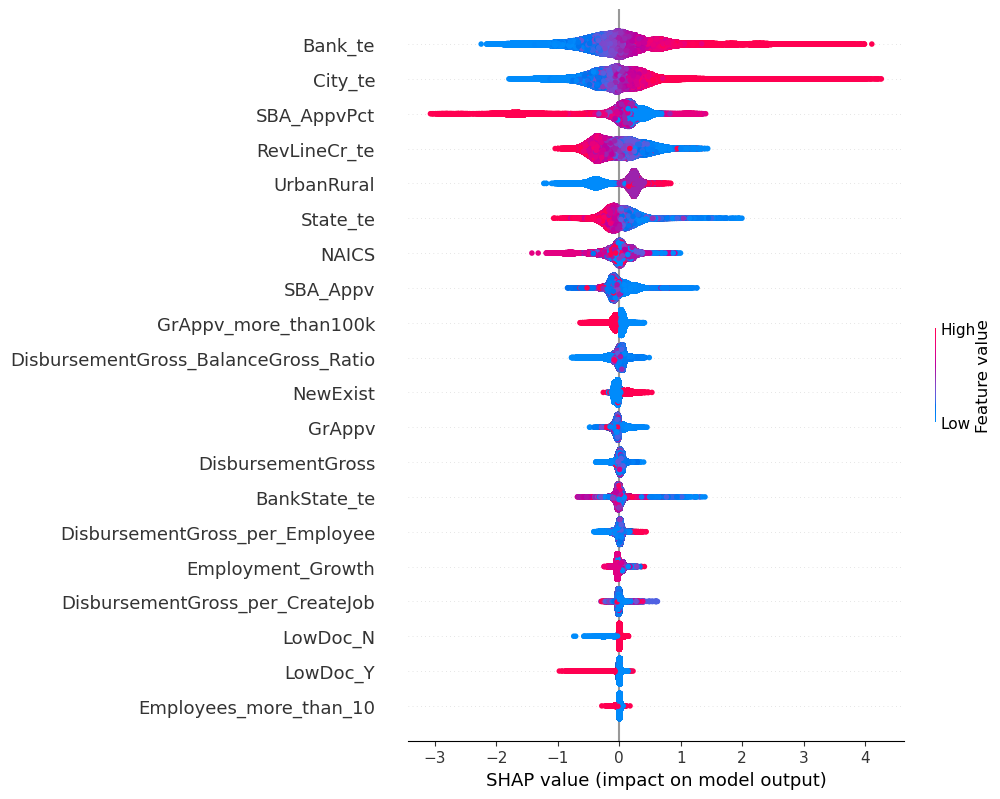

In [46]:
examine_all_reason_codes(train, gbm_optimal)